In [2]:
import pandas as pd
import numpy as np

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle

In [4]:
match = pd.read_csv('/content/matches (1).csv')
delivery = pd.read_csv('deliveries.csv')

In [8]:
match.sample(5)

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
368,369,IPL-2012,Delhi,15-05-2012,Kings XI Punjab,Delhi Daredevils,Kings XI Punjab,bat,normal,0,Delhi Daredevils,0,5,UT Yadav,Feroz Shah Kotla,HDPK Dharmasena,BNJ Oxenford,NaN
524,525,IPL-2015,Bangalore,13-04-2015,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,field,normal,0,Sunrisers Hyderabad,0,8,DA Warner,M Chinnaswamy Stadium,RM Deshpande,RK Illingworth,NaN
643,7901,IPL-2018,Bengaluru,13-04-2018,Kings XI Punjab,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Royal Challengers Bangalore,0,4,UT Yadav,M Chinnaswamy Stadium,S Ravi,A.D Deshmukh,C Shamshuddin
576,577,IPL-2016,Mumbai,09-04-2016,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,bat,normal,0,Rising Pune Supergiants,0,9,AM Rahane,Wankhede Stadium,HDPK Dharmasena,CK Nandan,NaN
275,276,IPL-2011,Chennai,04-05-2011,Rajasthan Royals,Chennai Super Kings,Rajasthan Royals,bat,normal,0,Chennai Super Kings,0,8,MEK Hussey,"MA Chidambaram Stadium, Chepauk",SS Hazare,RB Tiffin,NaN


In [10]:
delivery.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,1.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,2.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,3.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,4.0,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,4.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.0,5.0,DA Warner,S Dhawan,TS Mills,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,2.0,NaN,NaN,NaN


In [47]:
# --- Step 3: Preprocess Match Data ---
# Calculate total runs scored in 1st innings
total_score_df = delivery.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()
total_score_df = total_score_df[total_score_df['inning'] == 1]

# Merge with match dataframe to get target
match_df = match.merge(total_score_df[['match_id', 'total_runs']], left_on='id', right_on='match_id')

# Standardize team names
match_df['team1'].replace({'Delhi Daredevils': 'Delhi Capitals', 'Deccan Chargers': 'Sunrisers Hyderabad'}, inplace=True)
match_df['team2'].replace({'Delhi Daredevils': 'Delhi Capitals', 'Deccan Chargers': 'Sunrisers Hyderabad'}, inplace=True)

# Keep only consistent teams
teams = ['Sunrisers Hyderabad', 'Mumbai Indians', 'Royal Challengers Bangalore', 'Kolkata Knight Riders',
         'Kings XI Punjab', 'Chennai Super Kings', 'Rajasthan Royals', 'Delhi Capitals']

match_df = match_df[(match_df['team1'].isin(teams)) & (match_df['team2'].isin(teams)) & (match_df['dl_applied'] == 0)]
match_df = match_df[['match_id', 'city', 'winner', 'total_runs']]


/tmp/ipython-input-47-2467936270.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  match_df['team1'].replace({'Delhi Daredevils': 'Delhi Capitals', 'Deccan Chargers': 'Sunrisers Hyderabad'}, inplace=True)
/tmp/ipython-input-47-2467936270.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

In [48]:
# --- Step 4: Merge with Delivery Data ---
delivery_df = match_df.merge(delivery, on='match_id')
delivery_df = delivery_df[delivery_df['inning'] == 2]

In [49]:
# --- Step 5: Feature Engineering ---
# Current score
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()

# Runs left
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']

# Balls left
delivery_df['balls_left'] = 120 - (delivery_df['over'] * 6 + delivery_df['ball'])

# Dismissals
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna('0')
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x: 0 if x == '0' else 1)

# Wickets fallen
delivery_df['wickets'] = 10 - delivery_df.groupby('match_id')['player_dismissed'].cumsum()

# CRR & RRR
delivery_df['crr'] = (delivery_df['current_score'] * 6) / (120 - delivery_df['balls_left'])
delivery_df['rrr'] = (delivery_df['runs_left'] * 6) / delivery_df['balls_left']

# Result (Win/Loss)
delivery_df['result'] = delivery_df.apply(lambda row: 1 if row['batting_team'] == row['winner'] else 0, axis=1)

In [50]:
# --- Step 6: Final Dataset ---
final_df = delivery_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
                        'wickets', 'total_runs_x', 'crr', 'rrr', 'result']]

# Drop rows with missing values or illogical scenarios
final_df.dropna(inplace=True)
final_df = final_df[final_df['balls_left'] > 0]
final_df = final_df[(final_df['runs_left'] >= 0)]
final_df = final_df[(final_df['rrr'] <= 100)]  # Logical cricket cap
final_df = final_df[(final_df['wickets'] >= 0) & (final_df['wickets'] <= 10)]

/tmp/ipython-input-50-1667669057.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.dropna(inplace=True)


In [51]:
final_df.describe()

,runs_left,balls_left,wickets,total_runs_x,crr,rrr,result
count,57241.000000,57241.000000,57241.000000,57241.000000,57241.000000,57241.000000,57241.000000
mean,94.602086,59.403452,7.686466,163.074981,6.208990,11.499616,0.529131
std,48.123624,31.708709,2.002444,28.903789,2.068751,8.507124,0.499155
min,0.000000,1.000000,0.000000,67.000000,0.000000,0.000000,0.000000
25%,57.000000,33.000000,6.000000,144.000000,5.156250,7.840000,0.000000
50%,94.000000,60.000000,8.000000,164.000000,6.444444,9.680000,1.000000
75%,130.000000,87.000000,9.000000,183.000000,7.529412,12.218182,1.000000
max,246.000000,113.000000,10.000000,246.000000,15.000000,100.000000,1.000000


In [52]:
final_df.columns


Index(['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
       'wickets', 'total_runs_x', 'crr', 'rrr', 'result'],
      dtype='object')

##Visualization

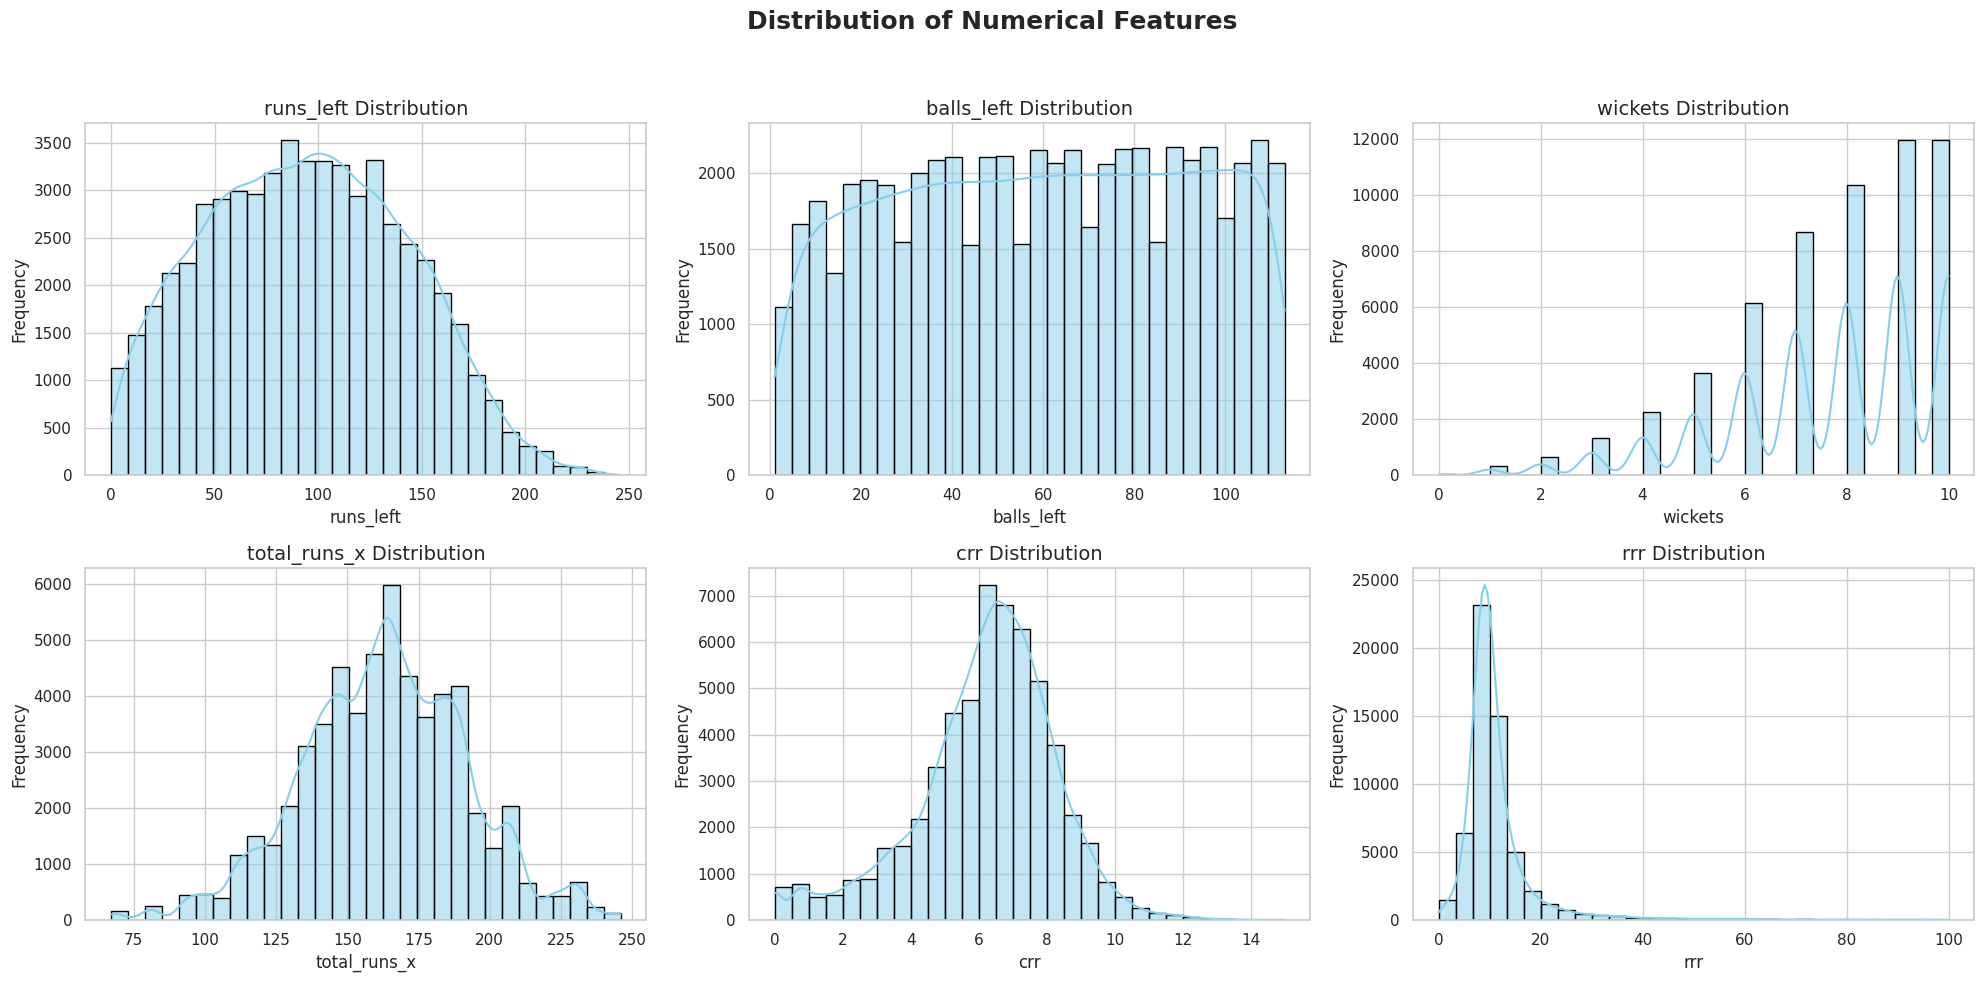

/tmp/ipython-input-54-3523582541.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x=col, palette="Set2", order=final_df[col].value_counts().index, ax=ax)
/tmp/ipython-input-54-3523582541.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x=col, palette="Set2", order=final_df[col].value_counts().index, ax=ax)
/tmp/ipython-input-54-3523582541.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x=col, palette="Set2", order=final_df[col].value_counts().index, ax=ax)
/tmp/ipython-input-54-

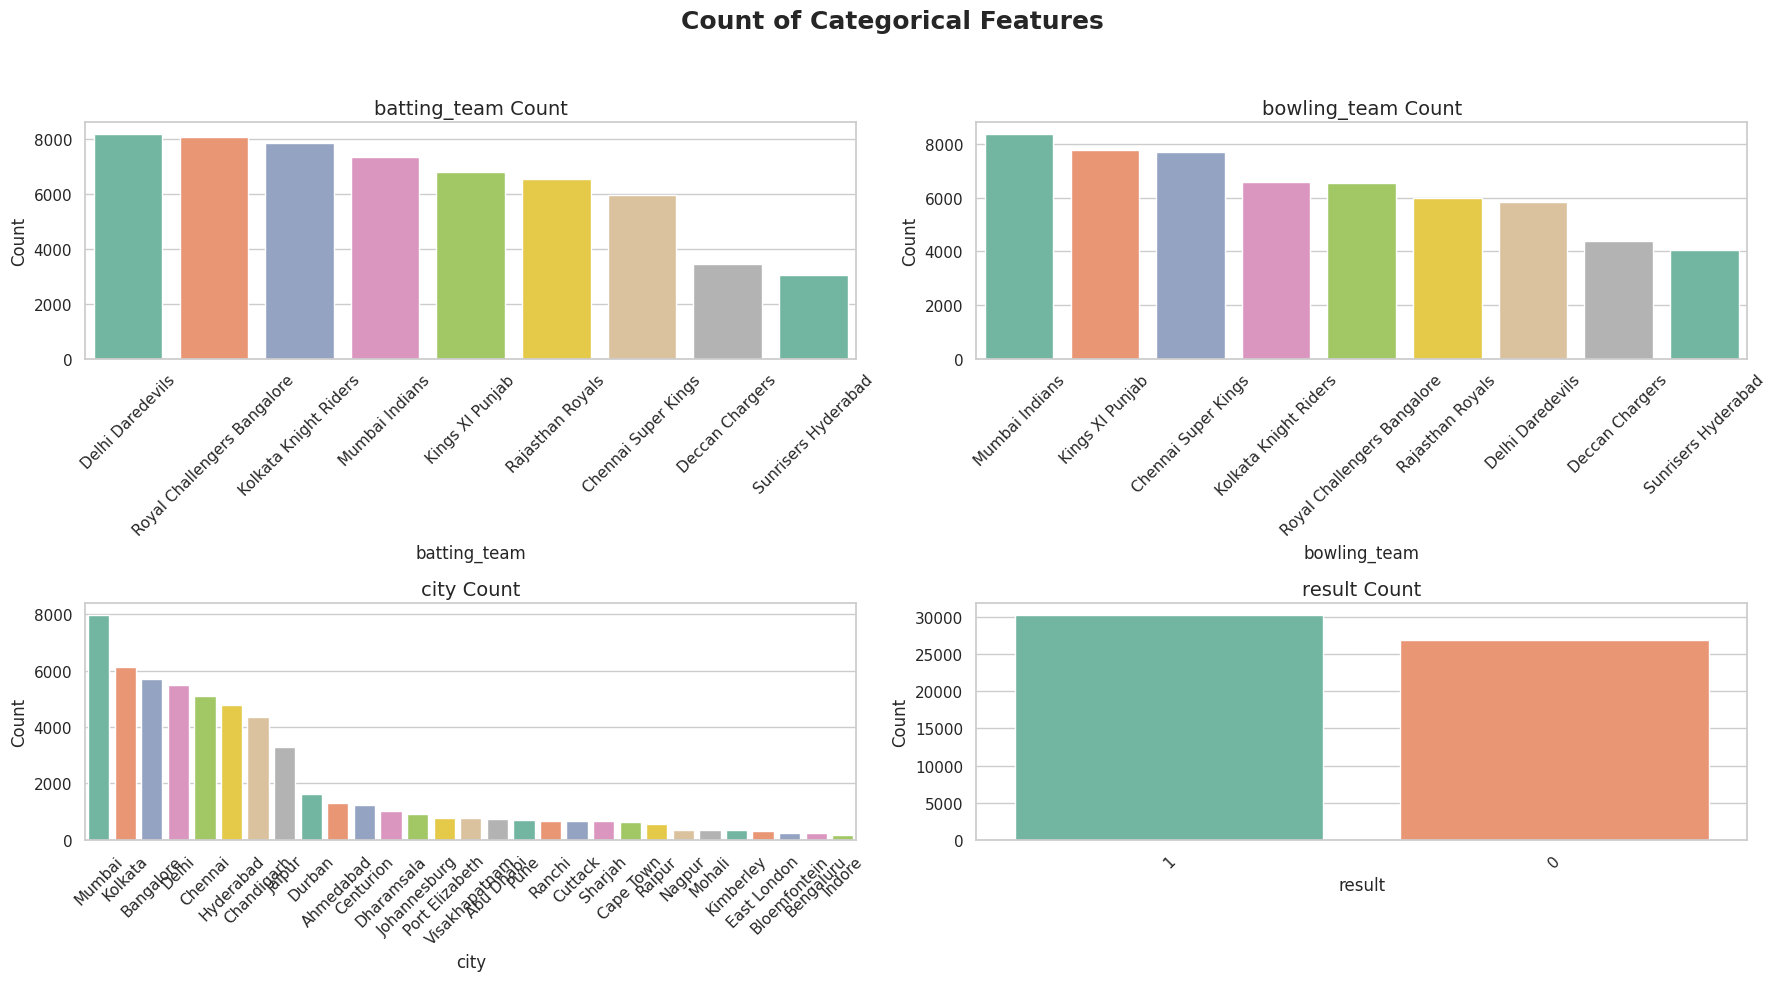

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set aesthetic theme
sns.set(style="whitegrid")
# plt.style.use('seaborn-vibrant')  # For better visuals

# Define numerical and categorical columns
numerical_cols = ['runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']
categorical_cols = ['batting_team', 'bowling_team', 'city', 'result']

# --- Plot Numerical Columns (Histograms & KDEs) ---
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.suptitle('Distribution of Numerical Features', fontsize=18, fontweight='bold')

for i, col in enumerate(numerical_cols):
    ax = axes[i // 3, i % 3]
    sns.histplot(data=final_df, x=col, kde=True, bins=30, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'{col} Distribution', fontsize=14)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Plot Categorical Columns (Count Plots) ---
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
fig.suptitle('Count of Categorical Features', fontsize=18, fontweight='bold')

for i, col in enumerate(categorical_cols):
    ax = axes[i // 2, i % 2]
    sns.countplot(data=final_df, x=col, palette="Set2", order=final_df[col].value_counts().index, ax=ax)
    ax.set_title(f'{col} Count', fontsize=14)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

###EDA

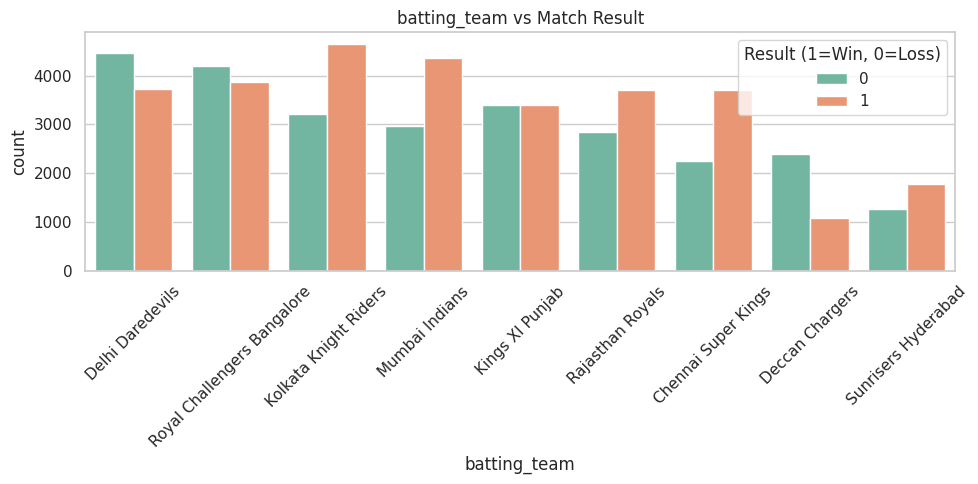

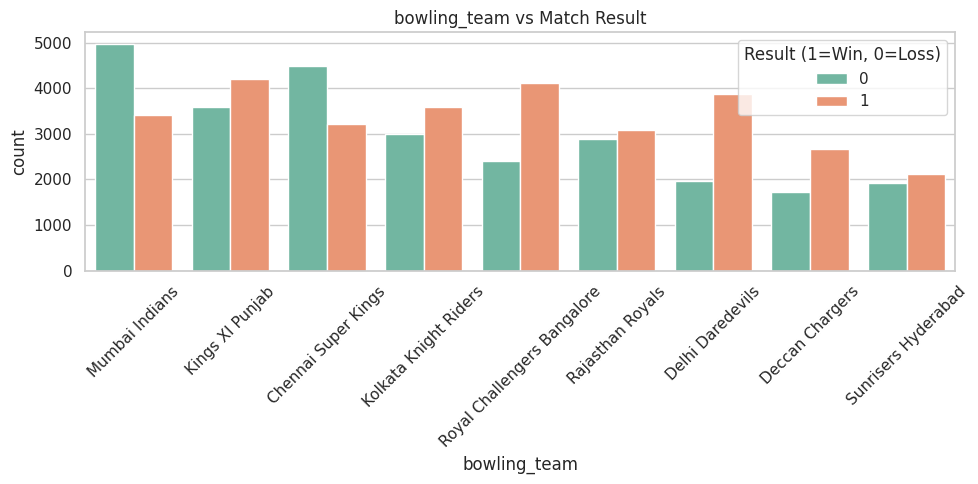

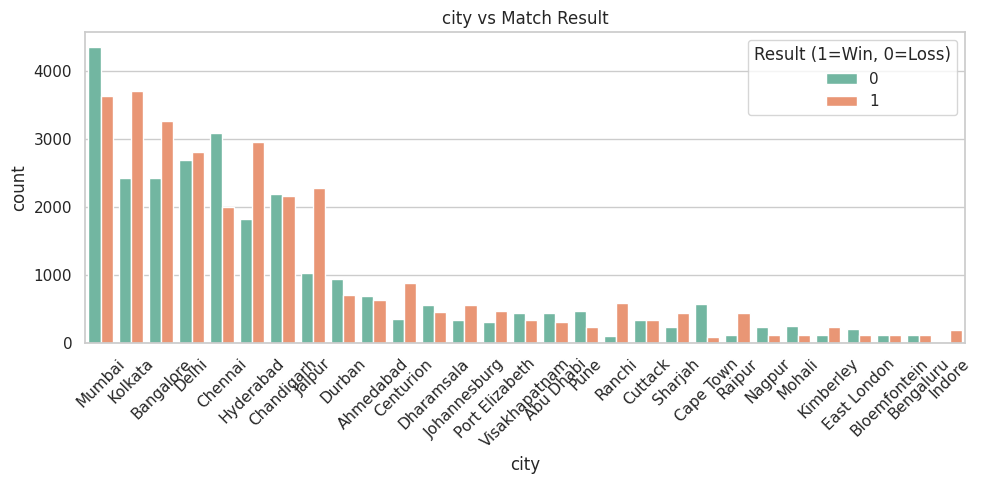

In [55]:
# Set visual style
sns.set(style='whitegrid', palette='Set2')
plt.rcParams['figure.figsize'] = (12, 6)

# 1. CATEGORICAL VARIABLES: batting_team, bowling_team, city
categorical_cols = ['batting_team', 'bowling_team', 'city']

for col in categorical_cols:
    plt.figure(figsize=(10,5))
    ax = sns.countplot(data=final_df, x=col, order=final_df[col].value_counts().index, hue='result')
    plt.title(f'{col} vs Match Result')
    plt.xticks(rotation=45)
    plt.legend(title='Result (1=Win, 0=Loss)')
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-57-2844696388.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


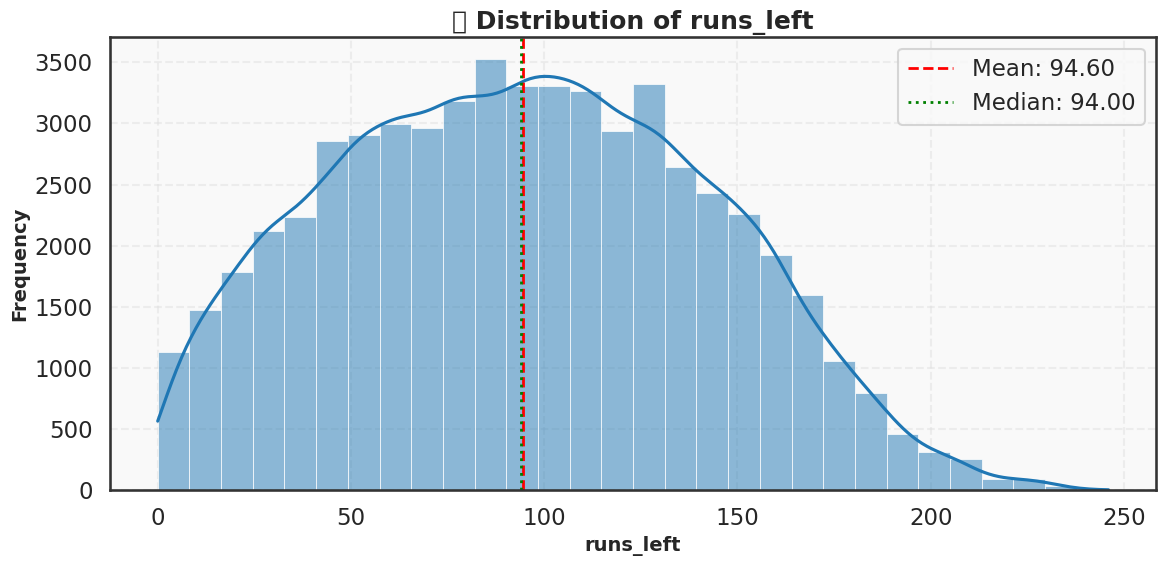

/tmp/ipython-input-57-2844696388.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


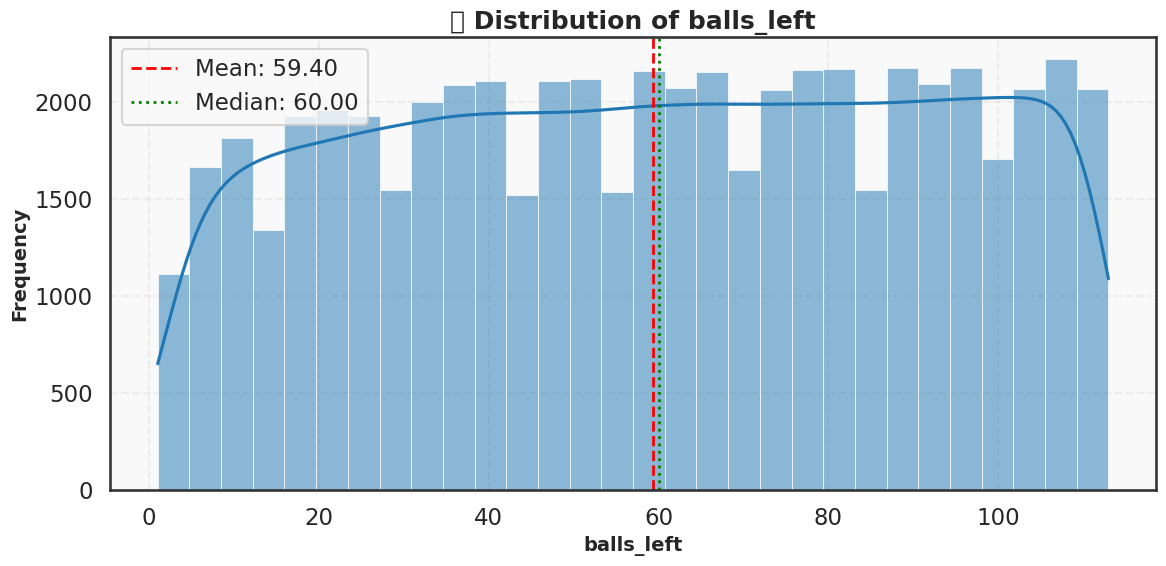

/tmp/ipython-input-57-2844696388.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


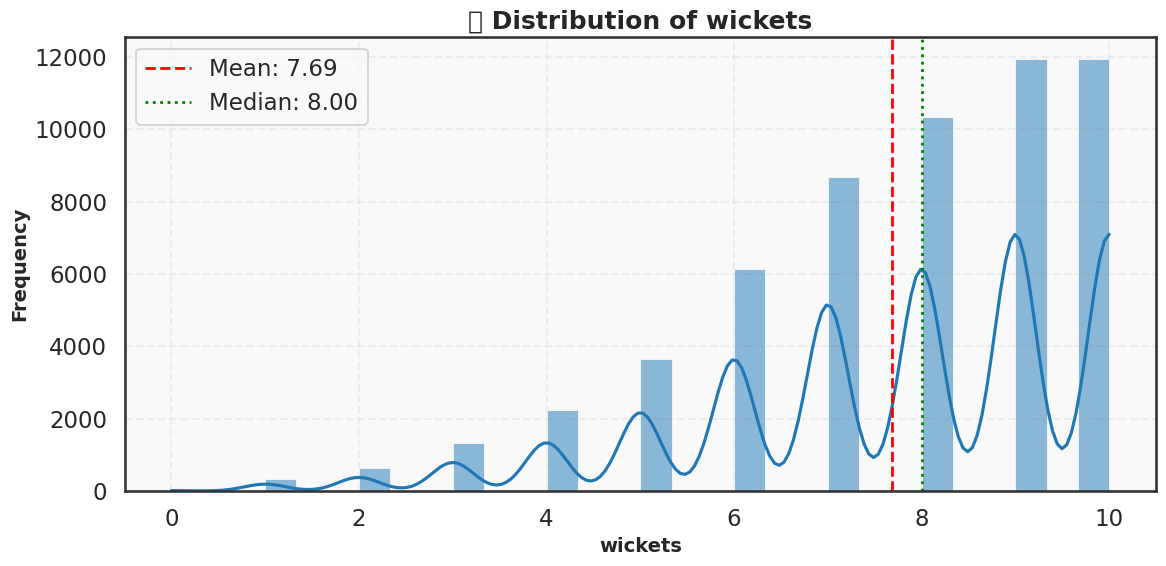

/tmp/ipython-input-57-2844696388.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


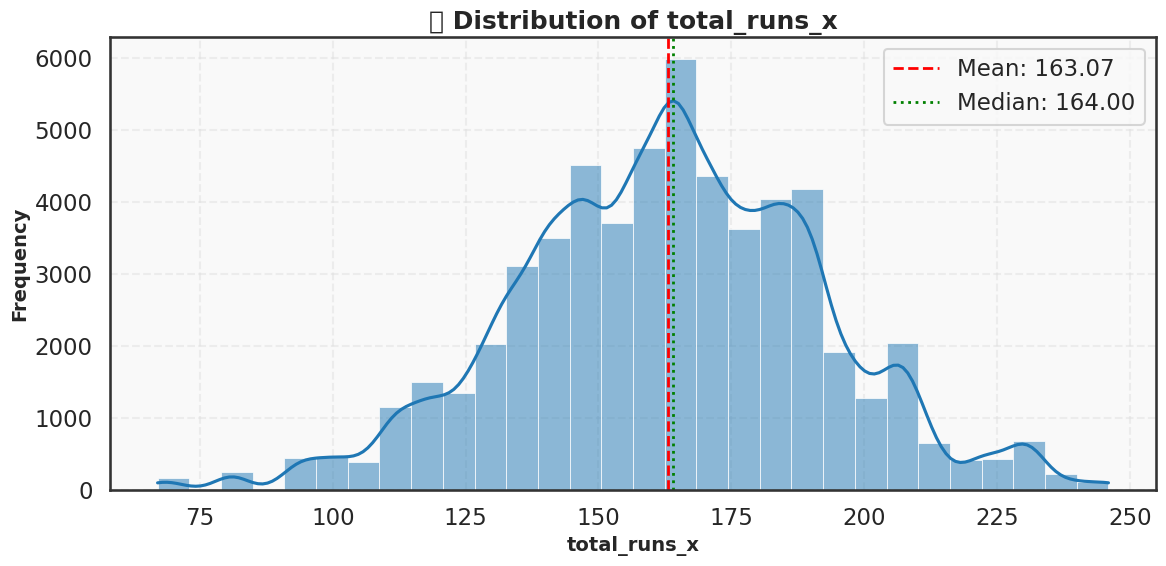

/tmp/ipython-input-57-2844696388.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


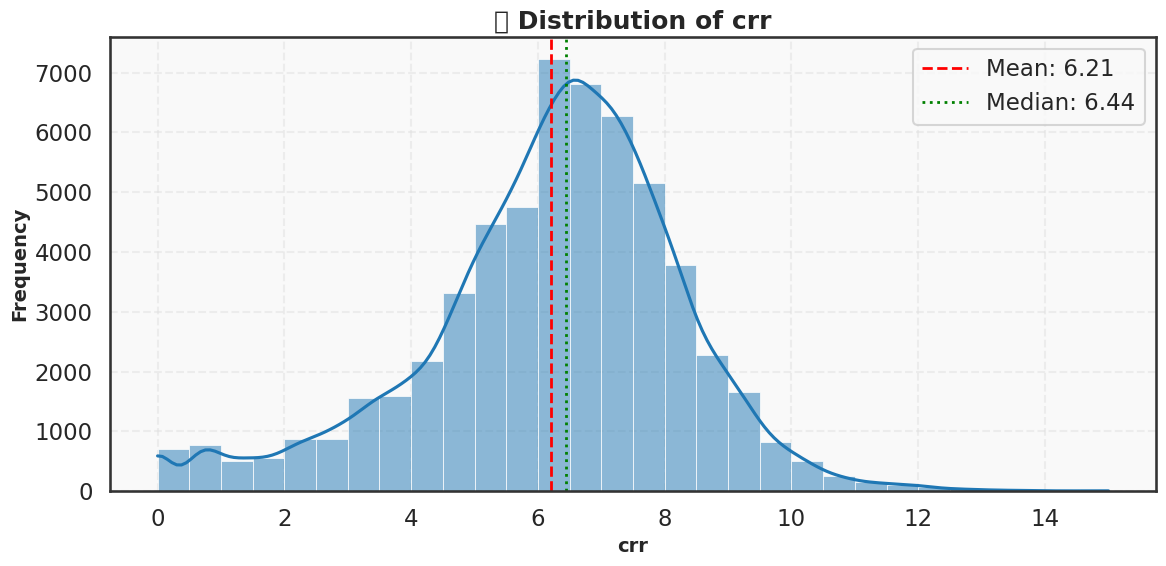

/tmp/ipython-input-57-2844696388.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


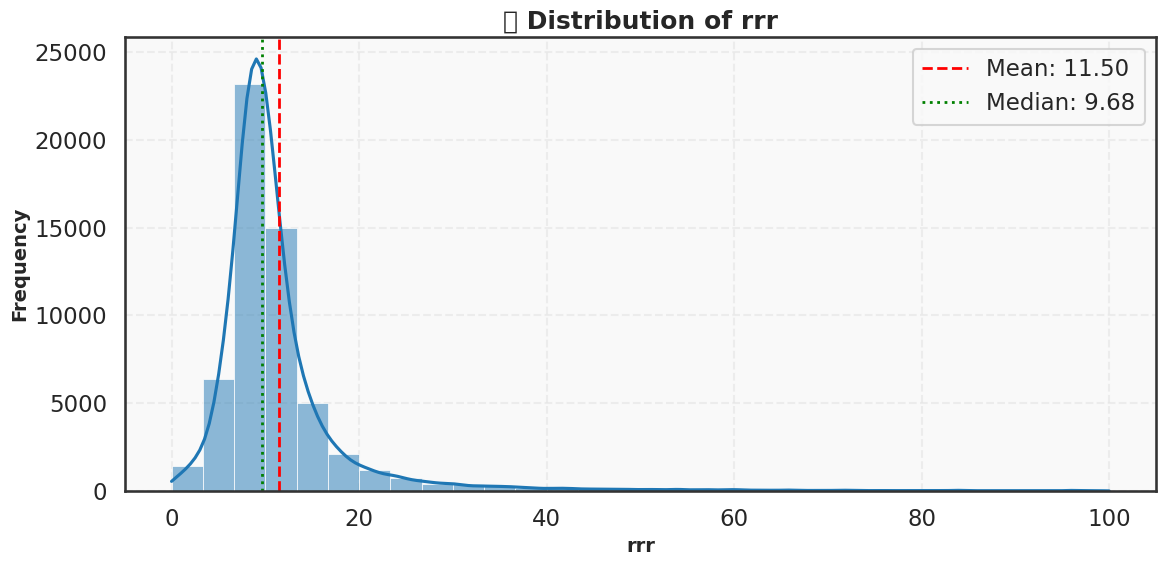

In [57]:
# 2. NUMERICAL VARIABLES: histograms + KDE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a custom theme
sns.set(style='white', context='talk', palette='deep')
plt.rcParams['axes.facecolor'] = '#f9f9f9'
plt.rcParams['grid.color'] = '#e0e0e0'
plt.rcParams['axes.edgecolor'] = '#333'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

numerical_cols = ['runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']

for col in numerical_cols:
    plt.figure(figsize=(12, 6))

    # Histogram + KDE
    sns.histplot(final_df[col], kde=True, bins=30, color='#1f77b4', edgecolor='white', linewidth=0.5)

    # Add mean and median lines
    mean_val = final_df[col].mean()
    median_val = final_df[col].median()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle=':', linewidth=2, label=f'Median: {median_val:.2f}')

    # Title and labels
    plt.title(f'📊 Distribution of {col}', fontsize=18, weight='bold')
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



/tmp/ipython-input-58-964288106.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_df, x='result', y=col, palette=colors, linewidth=2.5, width=0.5)
/tmp/ipython-input-58-964288106.py:24: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


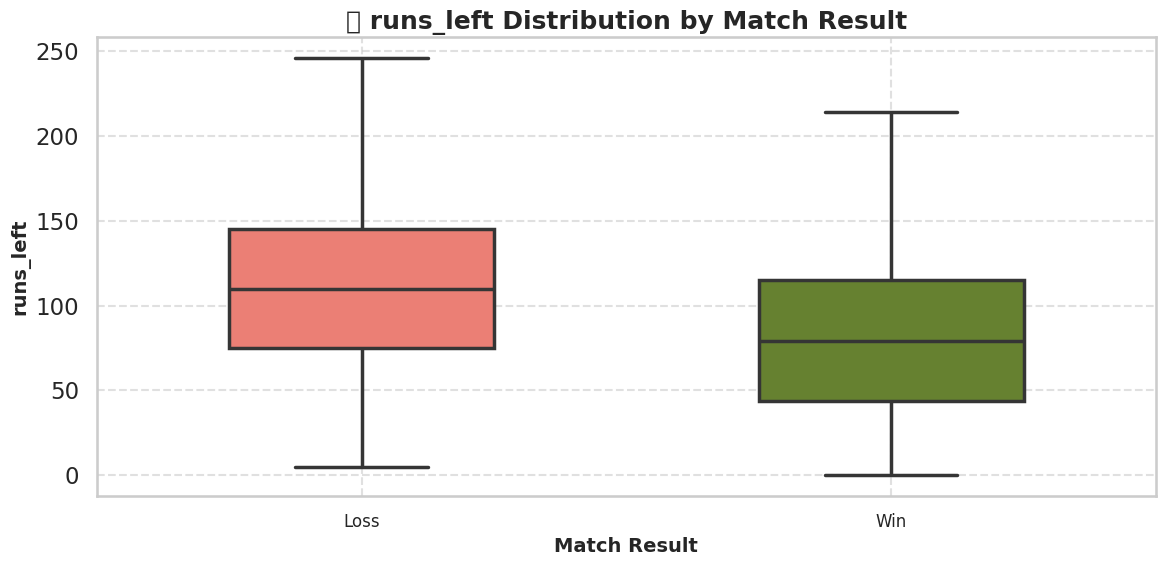

/tmp/ipython-input-58-964288106.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_df, x='result', y=col, palette=colors, linewidth=2.5, width=0.5)
/tmp/ipython-input-58-964288106.py:24: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


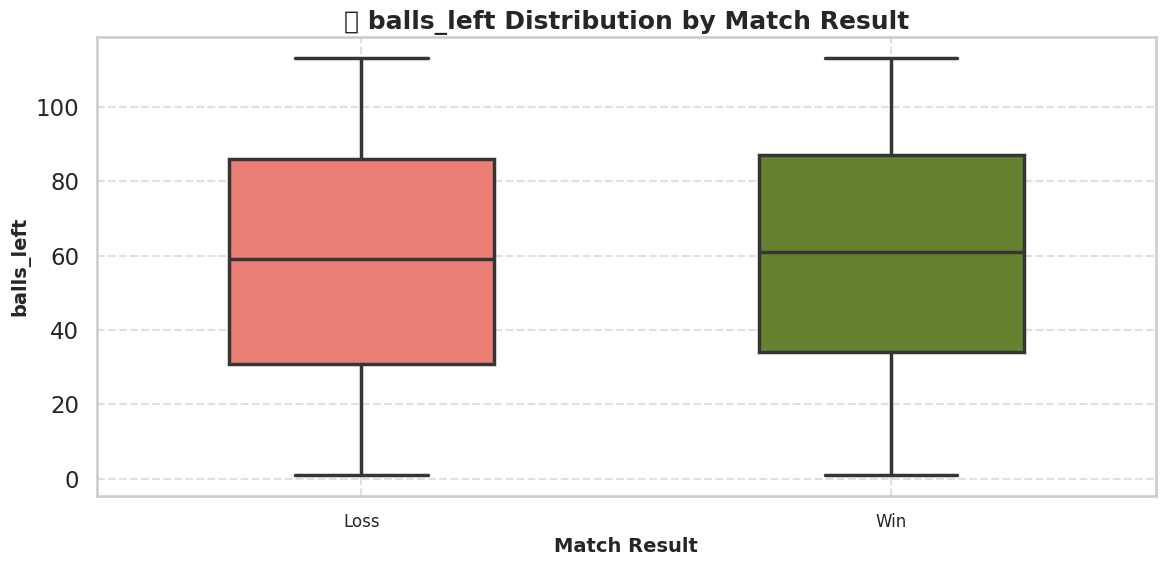

/tmp/ipython-input-58-964288106.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_df, x='result', y=col, palette=colors, linewidth=2.5, width=0.5)
/tmp/ipython-input-58-964288106.py:24: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


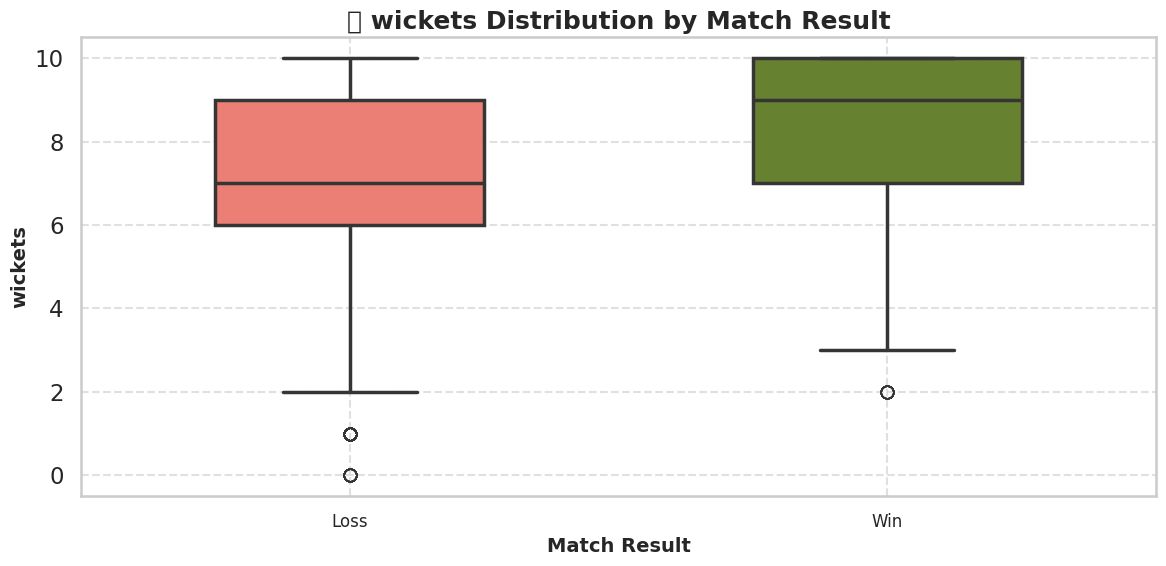

/tmp/ipython-input-58-964288106.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_df, x='result', y=col, palette=colors, linewidth=2.5, width=0.5)
/tmp/ipython-input-58-964288106.py:24: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


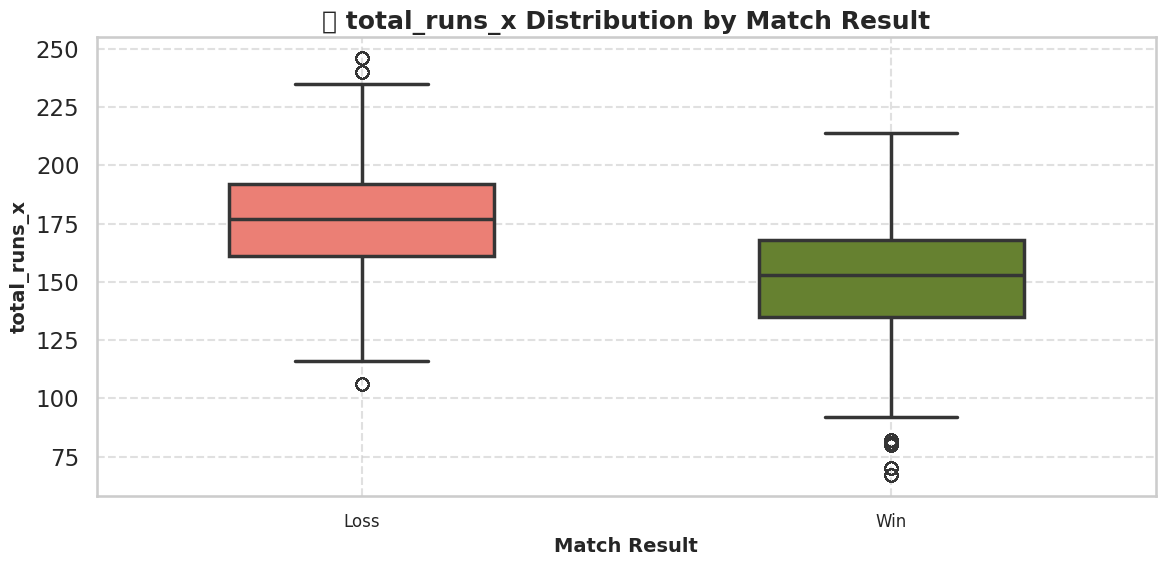

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


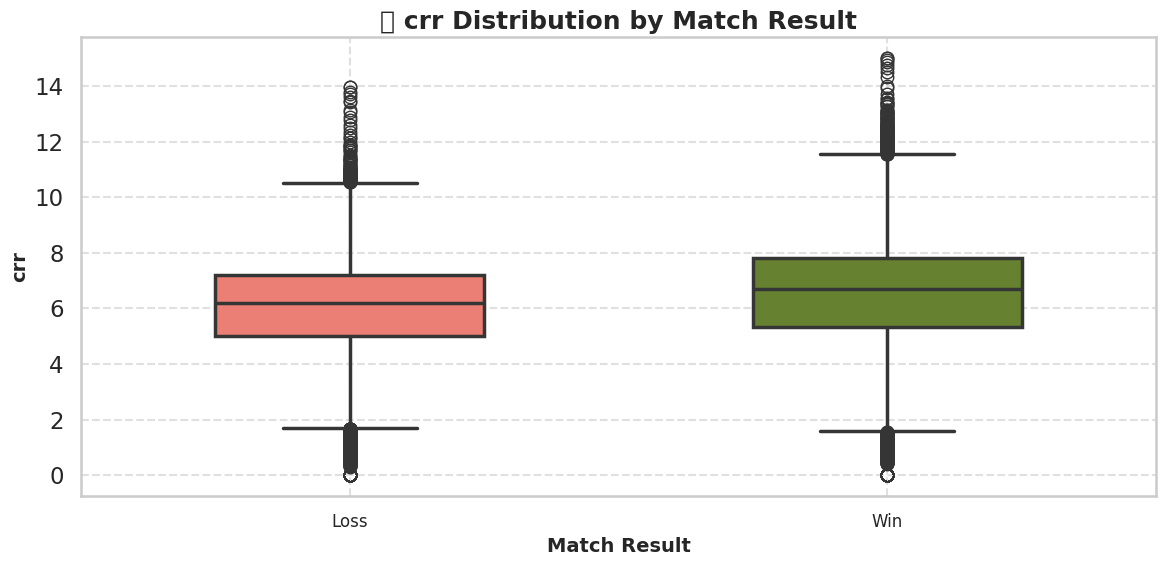

/tmp/ipython-input-58-964288106.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_df, x='result', y=col, palette=colors, linewidth=2.5, width=0.5)
/tmp/ipython-input-58-964288106.py:24: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


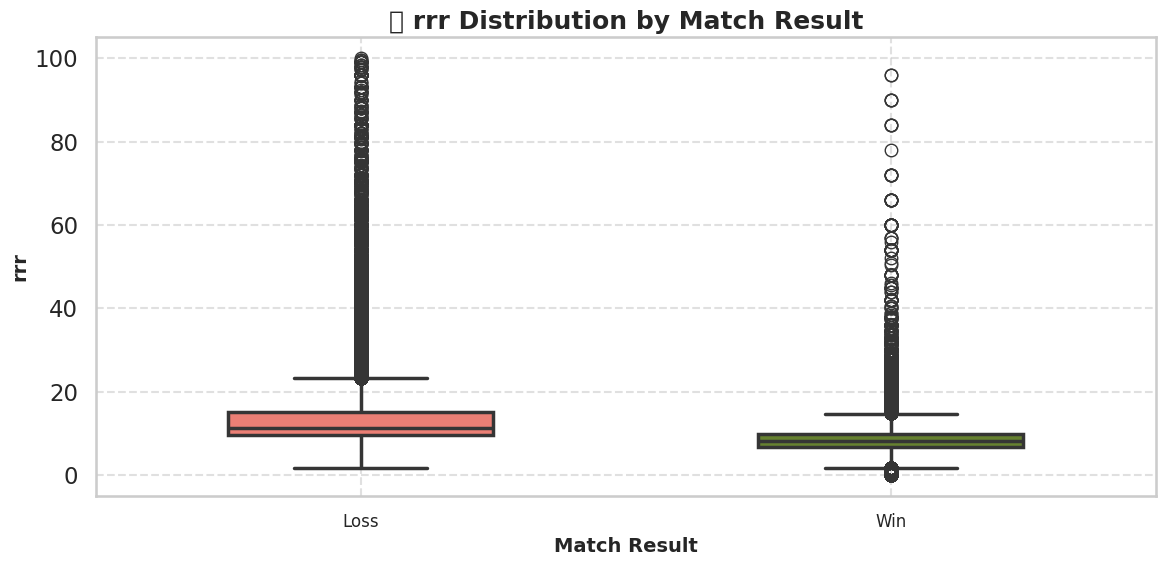

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='talk')

# Define numerical columns
numerical_cols = ['runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']

# Result labels
result_labels = ['Loss', 'Win']
colors = ['#FF6F61', '#6B8E23']  # Coral Red, Olive Green

for col in numerical_cols:
    plt.figure(figsize=(12, 6))

    sns.boxplot(data=final_df, x='result', y=col, palette=colors, linewidth=2.5, width=0.5)

    plt.title(f'📦 {col} Distribution by Match Result', fontsize=18, weight='bold')
    plt.xlabel('Match Result', fontsize=14)
    plt.ylabel(col, fontsize=14)
    plt.xticks([0, 1], result_labels, fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


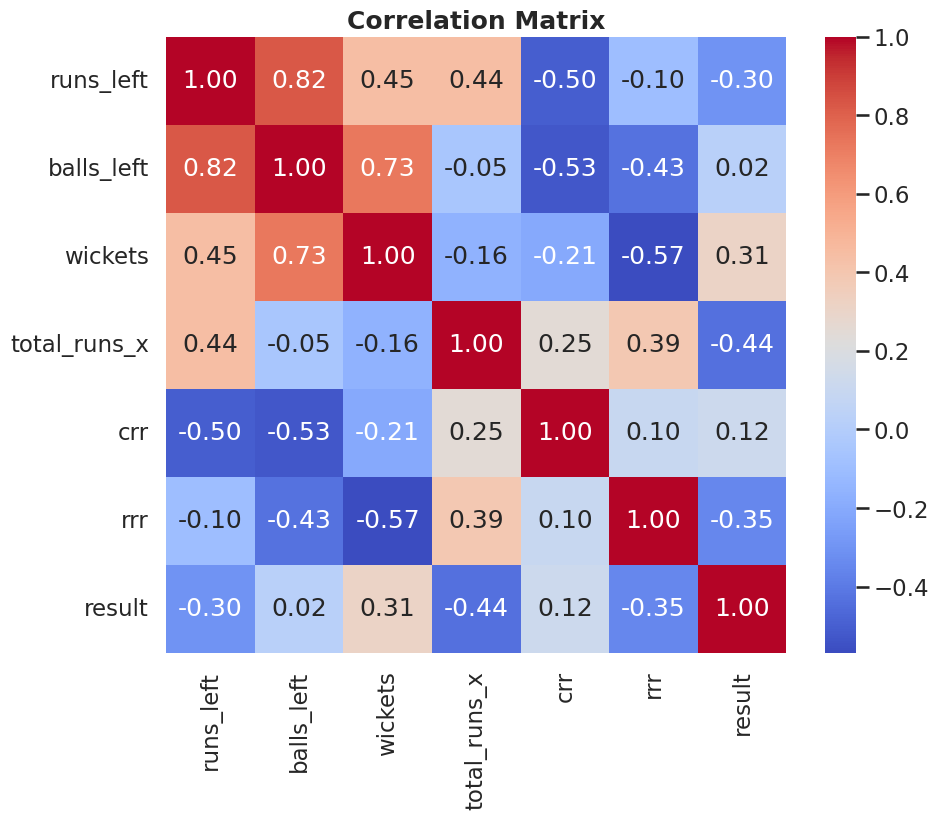

In [59]:
# 4. CORRELATION MATRIX
plt.figure(figsize=(10, 8))
sns.heatmap(final_df[numerical_cols + ['result']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

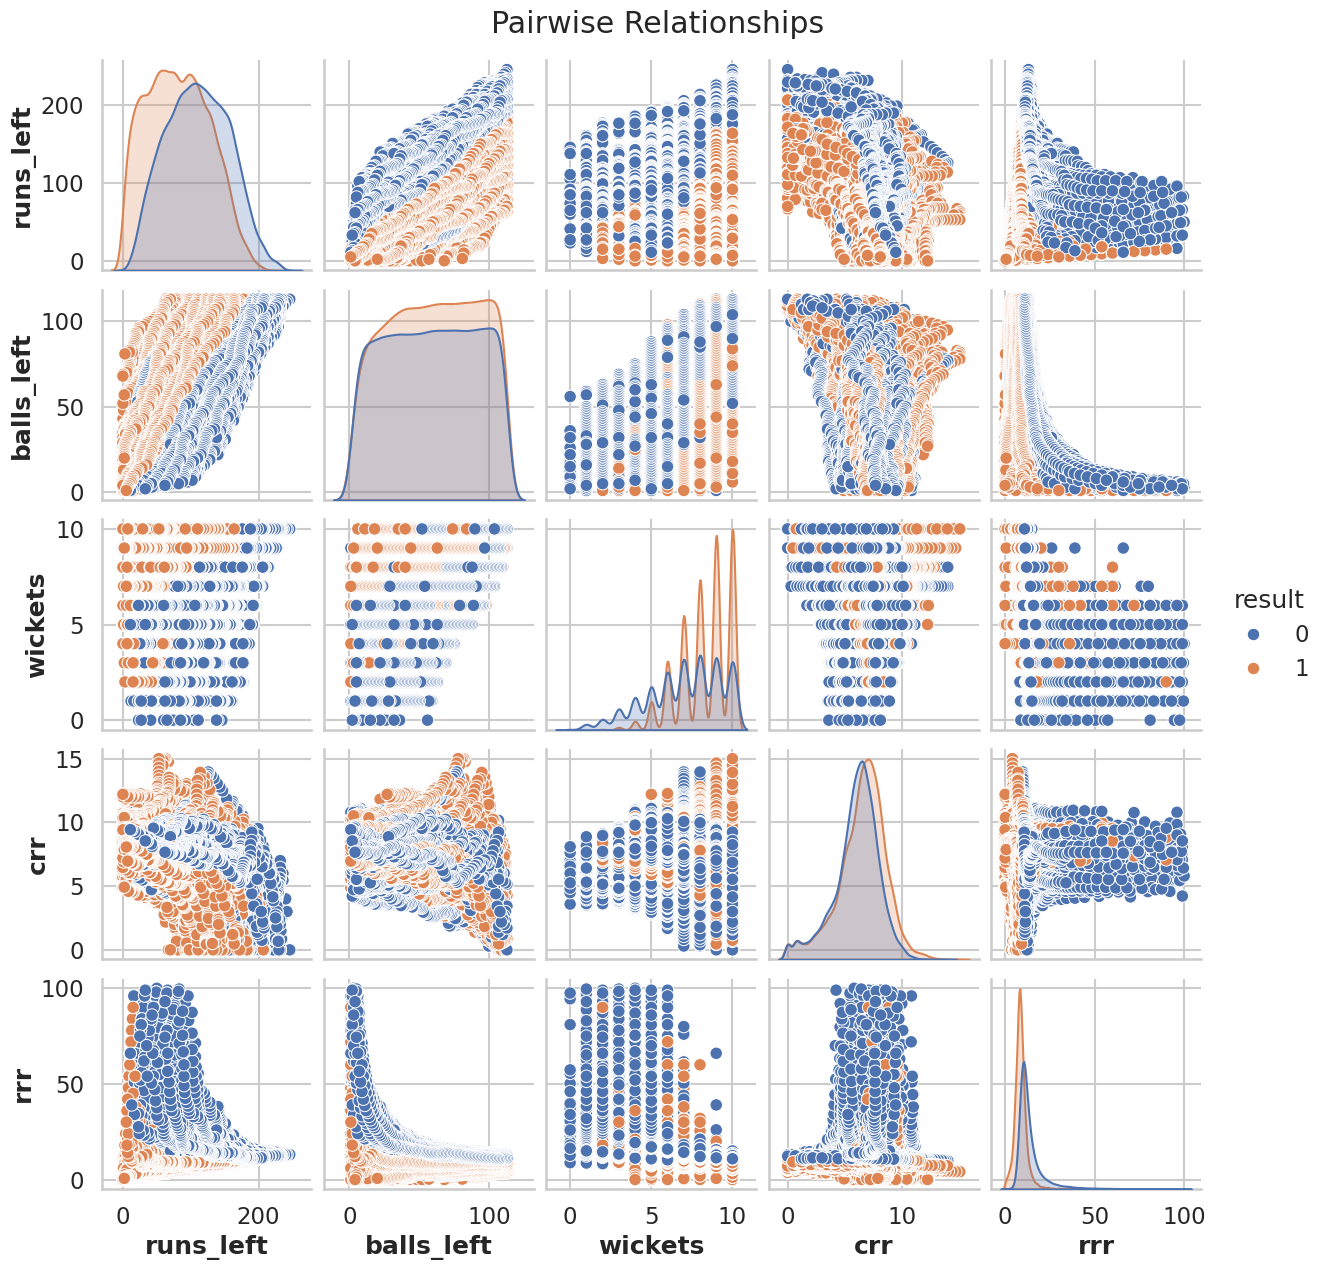

In [60]:
# 5. Pairplot for major numeric variables
sns.pairplot(final_df[['runs_left', 'balls_left', 'wickets', 'crr', 'rrr', 'result']], hue='result')
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

In [62]:
X = final_df.drop('result', axis=1)
y = final_df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 8: Model Pipeline ---
trf = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first'), ['batting_team', 'bowling_team', 'city'])
], remainder='passthrough')

In [67]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Define categorical and numerical columns based on your DataFrame
categorical_columns = ['batting_team', 'bowling_team', 'city']
numerical_columns = ['runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr'] # Assuming these are your numerical columns

# Use handle_unknown='ignore'
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Then add this encoder to your ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ]
)

In [68]:
final_df.head()

,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr,result
125,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,206.0,113.0,10,207.0,0.857143,10.938053,0
126,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,206.0,112.0,10,207.0,0.750000,11.035714,0
127,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,206.0,111.0,10,207.0,0.666667,11.135135,0
128,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,204.0,110.0,10,207.0,1.800000,11.127273,0
129,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,200.0,109.0,10,207.0,3.818182,11.009174,0


In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Assuming your DataFrame is called df and the target column is 'result' (0 or 1)
# Replace with your actual DataFrame and target
X = df.drop(columns='result')
y = df['result']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define columns
categorical_columns = ['batting_team', 'bowling_team', 'city']
numerical_columns = ['runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']

# Preprocessor: OneHotEncode categorical and scale numerical
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ]
)

# Function to evaluate and print metrics
def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    try:
        cv_f1 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1').mean()
    except:
        cv_f1 = np.nan  # For XGBoost if parallelism or data issues arise

    # Print results
    print(f"\n{name} Performance:")
    print(f"CV_F1      : {cv_f1:.4f}")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Precision  : {prec:.4f}")
    print(f"Recall     : {rec:.4f}")
    print(f"F1-score   : {f1:.4f}")
    print(f"ROC AUC    : {roc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return {
        'Model': name,
        'CV_F1': cv_f1,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC AUC': roc
    }

# Define pipelines
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []

# Train and evaluate all models
for model_name, clf in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    result = evaluate_model(model_name, pipe, X_train, y_train, X_test, y_test)
    results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\nSummary of All Model Performance:")
print(results_df)



Logistic Regression Performance:
CV_F1      : 0.8089
Accuracy   : 0.8020
Precision  : 0.8126
Recall     : 0.8088
F1-score   : 0.8107
ROC AUC    : 0.8861
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79      5482
           1       0.81      0.81      0.81      6035

    accuracy                           0.80     11517
   macro avg       0.80      0.80      0.80     11517
weighted avg       0.80      0.80      0.80     11517


Random Forest Performance:
CV_F1      : 0.9986
Accuracy   : 0.9980
Precision  : 0.9977
Recall     : 0.9985
F1-score   : 0.9981
ROC AUC    : 0.9999
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5482
           1       1.00      1.00      1.00      6035

    accuracy                           1.00     11517
   macro avg       1.00      1.00      1.00     11517
weighted avg       1.00      1.00      1.00     115

In [70]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Fix randomness
RANDOM_STATE = 42

# ----- Step 1: Preprocessing -----
categorical_columns = ['batting_team', 'bowling_team', 'city']
numerical_columns = ['runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']
target = 'result'

X = df[categorical_columns + numerical_columns]
y = df[target]

# ----- Step 2: Train-test Split -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# ----- Step 3: Preprocessing Pipeline -----
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns),
    ('num', StandardScaler(), numerical_columns)
])

# ----- Step 4: Model Pipelines -----
# Random Forest
rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_leaf=4, random_state=RANDOM_STATE))
])

# XGBoost
xgb_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8,
        colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss',
        random_state=RANDOM_STATE))
])

# SVC
svc_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', SVC(C=1.0, kernel='rbf', probability=True, random_state=RANDOM_STATE))
])

# ----- Step 5: Training -----
rf_pipe.fit(X_train, y_train)
xgb_pipe.fit(X_train, y_train)
svc_pipe.fit(X_train, y_train)

# ----- Step 6: Evaluation -----
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    if y_proba is not None:
        print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Evaluate each model
evaluate_model(rf_pipe, "Random Forest")
evaluate_model(xgb_pipe, "XGBoost")
evaluate_model(svc_pipe, "SVC")



===== Random Forest =====
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5457
           1       0.89      0.90      0.90      6060

    accuracy                           0.89     11517
   macro avg       0.89      0.89      0.89     11517
weighted avg       0.89      0.89      0.89     11517

Accuracy: 0.8899018841712252
Precision: 0.8935611038107752
Recall: 0.8976897689768977
F1 Score: 0.8956206783009549
ROC AUC: 0.9665111755815493

===== XGBoost =====
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5457
           1       0.89      0.90      0.89      6060

    accuracy                           0.89     11517
   macro avg       0.89      0.89      0.89     11517
weighted avg       0.89      0.89      0.89     11517

Accuracy: 0.8878180081618477
Precision: 0.8858853998057624
Recall: 0.9031353135313531
F1 Score: 0.8944271939859454
ROC AUC: 0.962710836779115

===== SVC ==